<a href="https://colab.research.google.com/github/michelleaeh/CE888_Laboratory/blob/master/Laboratory7/Exercise_4_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "michelleespinosa" # username from the json file
os.environ['KAGGLE_KEY'] = "0f7da6a6d10770e685bf1124561d0341" # key from the json file
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia # api copied from kaggle

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# Upload data
from zipfile import ZipFile

file_name = "/content/chest-xray-pneumonia.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [0]:
train_dir='/content/chest_xray/train'
validation_dir='/content/chest_xray/val'
test_dir='/content/chest_xray/test'
train_N_dir='/content/chest_xray/train/NORMAL'
train_P_dir='/content/chest_xray/train/PNEUMONIA'
val_N_dir='/content/chest_xray/val/NORMAL'
val_P_dir='/content/chest_xray/val/PNEUMONIA'
test_N_dir='/content/chest_xray/test/NORMAL'
test_P_dir='/content/chest_xray/test/PNEUMONIA'

In [4]:
from keras import layers
from keras import models
!pip install tensorflow==1.14.0

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)  

In [5]:
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Using ImageDataGenerator to read images from directories
As you know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:

* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. Keras has a module with image-processing helper tools, located at keras.preprocessing.image. In particular, it contains the class ImageDataGenerator,which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), 
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Let’s fit the model to the data using the generator. You do so using the fit_generator method, the equivalent of fit for data generators like this one. It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely,like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring anepoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps—the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using fit_generator, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [7]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=10)


Epoch 1/30
100/100 [==============================] - 88s 877ms/step - loss: 0.5072 - acc: 0.7631 - val_loss: 0.9410 - val_acc: 0.6250
Epoch 2/30
100/100 [==============================] - 87s 874ms/step - loss: 0.3139 - acc: 0.8660 - val_loss: 0.6817 - val_acc: 0.6875
Epoch 3/30
100/100 [==============================] - 90s 897ms/step - loss: 0.2259 - acc: 0.9105 - val_loss: 1.3629 - val_acc: 0.5625
Epoch 4/30
100/100 [==============================] - 89s 894ms/step - loss: 0.1536 - acc: 0.9390 - val_loss: 0.9678 - val_acc: 0.6250
Epoch 5/30
100/100 [==============================] - 90s 898ms/step - loss: 0.1613 - acc: 0.9355 - val_loss: 0.5043 - val_acc: 0.8750
Epoch 6/30
100/100 [==============================] - 90s 895ms/step - loss: 0.1321 - acc: 0.9544 - val_loss: 0.5262 - val_acc: 0.7500
Epoch 7/30
100/100 [==============================] - 90s 901ms/step - loss: 0.1292 - acc: 0.9495 - val_loss: 0.9714 - val_acc: 0.6250
Epoch 8/30
100/100 [==============================] - 

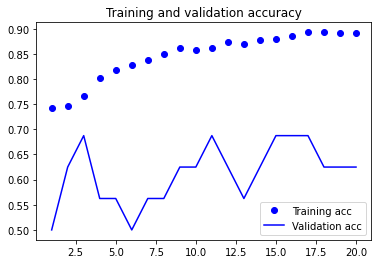

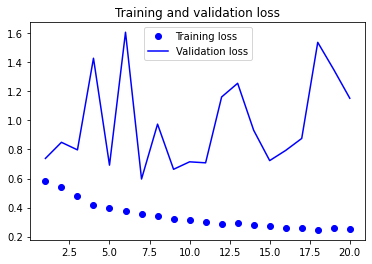

In [11]:
model.save('x_ray.h5')

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Convolutional Networks with Dropout

![alt text](https://camo.githubusercontent.com/ee6fa1073247cd2c3d241300caf110d7a7541bc5/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f3830302f312a4972644a355067684439596f4f7956415137334d4a772e676966)

Ref: https://github.com/mneha4/Training-Neural-Nets---Guidelines

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [10]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 156s 2s/step - loss: 0.5804 - acc: 0.7416 - val_loss: 0.7384 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 163s 2s/step - loss: 0.5413 - acc: 0.7469 - val_loss: 0.8493 - val_acc: 0.6250
Epoch 3/20
100/100 [==============================] - 160s 2s/step - loss: 0.4810 - acc: 0.7672 - val_loss: 0.7971 - val_acc: 0.6875
Epoch 4/20
100/100 [==============================] - 160s 2s/step - loss: 0.4199 - acc: 0.8012 - val_loss: 1.4279 - val_acc: 0.5625
Epoch 5/20
100/100 [==============================] - 163s 2s/step - loss: 0.3966 - acc: 0.8184 - val_loss: 0.6920 - val_acc: 0.5625
Epoch 6/20
100/100 [==============================] - 170s 2s/step - loss: 0.3743 - acc: 0.8272 - val_loss: 1.6068 - val_acc: 0.5000
Epoch 7/20
100/100 [==============================] - 170s 2s/step - loss: 0.3538 - acc: 0.8378 - val_loss: 0.5966 - val